In [24]:
# Pour que les changements dans les modules importés (bandits.py) soient pris en compte
%load_ext autoreload
%autoreload 2
# Pour afficher les figures dans le notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from SarsaAgent import SarsaAgent
from QlearningAgent import QlearningAgent
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import gym
from utils import moving_average
import pandas as pd

import pickle

## Parameters

In [3]:
alpha = 0.1   # learning rate
gamma = 1.0   # importance of next action
epsilon_0 = 1
beta_epsilon = 0.999  # influence exploration chance
n_action = 21


# Defining a random baseline 

In [ ]:
nb_episodes = 500

env = gym.make('MountainCarContinuous-v0').env
random_rewards = []
random_steps = []

for i_episode in range(nb_episodes):
    observation = env.reset()
    cum_rewards = 0
    t = 0
    while True:
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            random_steps.append(t)
            if i_episode %10 == 0:
                print("Episode finished after {} timesteps".format(t+1))
            break
        cum_rewards += reward
        t += 1
    random_rewards.append(cum_rewards)
env.close()

In [ ]:
rewards_baseline = np.mean(random_rewards)
steps_baseline = np.mean(random_steps)


In [9]:
df_out = pd.DataFrame( {"n_step" :random_steps, "reward": random_rewards,"epsilon": np.ones(500)})

file_name = 'historic_random_500_ep.csv'


In [10]:
df_out.head()

,n_step,reward,epsilon
0,12496,-411.987176,1.0
1,18506,-621.235888,1.0
2,5973,-198.902246,1.0
3,31320,-1042.875605,1.0
4,84228,-2821.316554,1.0


In [11]:
df_out.to_csv (r'history/'+ file_name, index = None, header=True)

# Training the agent 

In [8]:
nb_episodes = 8000
agent_name = 'qlearning'

if agent_name == 'sarsa':
    agent = SarsaAgent(alpha = alpha, gamma = gamma, epsilon = epsilon_0)
if agent_name == 'qlearning':
    agent = QlearningAgent(alpha = alpha, gamma = gamma, epsilon = epsilon_0)
    
env = gym.make('MountainCarContinuous-v0').env
sarsa_rewards = []
sarsa_steps = []
sarsa_epsilons = []
for i_episode in range(nb_episodes):
    #agent.epsilon = epsilon_0 / (1 + beta_epsilon * i_episode)
    agent.epsilon = epsilon_0 * (beta_epsilon ** i_episode)
    observation = env.reset()
    cum_rewards = 0
    t = 0
    sarsa_epsilons.append(agent.epsilon)
    while True:
        #env.render()
        #print(observation)
        state = agent.state
        action = [agent.choose_action(state)]
        observation, reward, done, info = env.step(action)
        new_state = agent.get_state_from_observation(observation)   
        #print(state, action[0], reward, new_state)
        agent.fit_step(state, action[0], reward, new_state)
        cum_rewards += reward
        if done:
            sarsa_steps.append(t)
            if i_episode%100 == 0:
                print("Episode n= {}, {} timesteps, Reward= {}, epsilon= {}".format(i_episode,t+1, cum_rewards, agent.epsilon))
            break
        t += 1
    sarsa_rewards.append(cum_rewards)
env.close()

Episode n= 0, 2209 timesteps, Reward= 26.006999999999707, epsilon= 1.0
Episode n= 100, 4136 timesteps, Reward= -40.300000000002115, epsilon= 0.9047921471137089
Episode n= 200, 4802 timesteps, Reward= -40.15700000000278, epsilon= 0.8186488294786356
Episode n= 300, 15372 timesteps, Reward= -384.105000000009, epsilon= 0.7407070321560992
Episode n= 400, 666 timesteps, Reward= 72.67999999999999, epsilon= 0.6701859060067401
Episode n= 500, 1711 timesteps, Reward= 33.9969999999999, epsilon= 0.6063789448611847
Episode n= 600, 2917 timesteps, Reward= 34.11800000000052, epsilon= 0.5486469074854967
Episode n= 700, 427 timesteps, Reward= 85.37300000000003, epsilon= 0.49641141343109896
Episode n= 800, 1057 timesteps, Reward= 52.009000000000064, epsilon= 0.4491491486100751
Episode n= 900, 665 timesteps, Reward= 60.74399999999989, epsilon= 0.4063866225452042
Episode n= 1000, 1068 timesteps, Reward= 83.72600000000001, epsilon= 0.36769542477096373
Episode n= 1100, 2511 timesteps, Reward= 69.89599999999

KeyboardInterrupt: 

## Exporting the agent and its training informations

In [7]:
df_out = pd.DataFrame( {"n_step" :sarsa_steps, "reward": sarsa_rewards,"epsilon": sarsa_epsilons})
file_name = 'historic_{}_episode-{}_eps-{}x{}powt_state-3x2_action-{}_5.csv'.format(agent_name,nb_episodes, epsilon_0, beta_epsilon, n_action)
#file_name = 'historic_{}_episode-{}_div(1+{}x{}t)_state-3x2_action-{}.csv'.format(agent_name,nb_episodes, epsilon_0, beta_epsilon, n_action)


df_out.to_csv (r'data/'+ file_name, index = None, header=True)

In [65]:
file_name = 'agent_{}_episode-{}_eps-{}x{}powt)_state-3x2_action-{} '.format(agent_name,nb_episodes, epsilon_0, beta_epsilon, n_action)
#file_name = 'agent_{}_episode-{}_eps-{}_div(1+{}x{}t)_state-3x2_action-{} '.format(agent_name,nb_episodes, epsilon_0, beta_epsilon, n_action)

outfile = open(r'agents/'+ file_name,'wb')
pickle.dump(agent,outfile)
outfile.close()

# Some useful plots

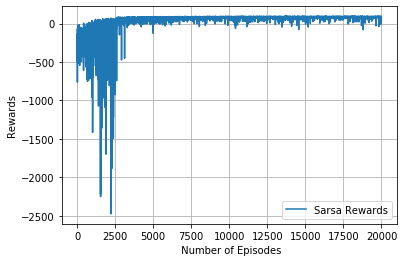

In [53]:
x = np.arange(len(sarsa_rewards)-4)

plt.plot(x, moving_average(sarsa_rewards,5), label = "Sarsa Rewards")
#plt.plot(x, np.full(shape=(nb_episodes-4),fill_value=rewards_baseline), "--g", label = "Random Baseline")
plt.ylabel("Rewards")
plt.xlabel(" Number of Episodes")
plt.legend()
plt.grid()
plt.show()

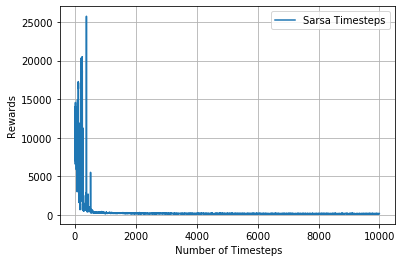

In [38]:
x = np.arange(len(sarsa_steps)-4)

plt.plot(x, moving_average(sarsa_steps,5), label = "Sarsa Timesteps")
#plt.plot(x, np.full(shape=(nb_episodes-4),fill_value=steps_baseline), "--g", label = "Random Baseline")
plt.ylabel("Rewards")
plt.xlabel(" Number of Timesteps")
plt.legend()
plt.grid()
plt.show()

# Testing and rendering the best policy of the agent

In [59]:
nb_episodes = 10


for i_episode in range(nb_episodes):
    observation = env.reset()
    t = 0
    cum_rewards = 0
    while True:
        env.render()
        #print(observation)
        state = agent.state
        action = [agent.choose_best_action(state)]
        observation, reward, done, info = env.step(action)
        new_state = agent.get_state_from_observation(observation)   
        #print(state, action[0], reward, new_state)
        cum_rewards += reward
        agent.fit_step(state, action[0], reward, new_state)
        if done:
            print("Episode n= {} , Episode finished after {} timesteps, Reward=".format(i_episode,t+1), cum_rewards)
            break
        t+=1
env.close()

Episode n= 0 , Episode finished after 129 timesteps, Reward= 96.02199999999999
Episode n= 1 , Episode finished after 231 timesteps, Reward= 93.83800000000002
Episode n= 2 , Episode finished after 381 timesteps, Reward= 88.88600000000008
Episode n= 3 , Episode finished after 246 timesteps, Reward= 91.96700000000003
Episode n= 4 , Episode finished after 158 timesteps, Reward= 94.40000000000002
Episode n= 5 , Episode finished after 231 timesteps, Reward= 92.43300000000002
Episode n= 6 , Episode finished after 262 timesteps, Reward= 91.57500000000002
Episode n= 7 , Episode finished after 395 timesteps, Reward= 87.77800000000009
Episode n= 8 , Episode finished after 463 timesteps, Reward= 86.73000000000012
Episode n= 9 , Episode finished after 1103 timesteps, Reward= 68.04499999999999
